<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/Time_series/Kaggle_forecast_product_demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DNN

Context

The dataset contains historical product demand for a manufacturing company with footprints globally. The company provides thousands of products within dozens of product categories. There are four central warehouses to ship products within the region it is responsible for. Since the products are manufactured in different locations all over the world, it normally takes more than one month to ship products via ocean to different central warehouses. If forecasts for each product in different central with reasonable accuracy for the monthly demand for month after next can be achieved, it would be beneficial to the company in multiple ways.

Content

Historical Product Demand.csv - CSV data file containing product demand for encoded product id's

Acknowledgements

This dataset is all real-life data and products/warehouse and category information encoded.

Inspiration

Is it possible to make forecasts for thousands of products (some of them are highly variable in terms of monthly demand) for the the month after next?

In [68]:
import pandas as pd
import numpy as np

data=pd.read_csv('/content/drive/My Drive/Data/Historical Product Demand.csv')
print(data.shape)
data.head()

(1048575, 5)


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


STEPS/Work Flow

- Import data and libaries: Self Explanatory
- Explore the Dataset: Check Nulls, Skew, Data Types, Univariate and Bivariate Analysis.
- Explore the Dataset as a Time Series: Min/Max Dates, Check Seasonality, Trends etc.
- ARIMA Model - Some Theory, Choose Best Params (Grid Seach), Build/Fit, Validation, Forecast Accuracy.
- The END.

## EDA

## Check null

In [69]:
data.Date=pd.to_datetime(data.Date)

In [70]:
data.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1048575,1048575,1048575,1037336,1048575
unique,2160,4,33,1729,3828
top,Product_1359,Whse_J,Category_019,2013-09-27 00:00:00,1000
freq,16936,764447,481099,2075,112682
first,NaN,NaN,NaN,2011-01-08 00:00:00,NaN
last,NaN,NaN,NaN,2017-01-09 00:00:00,NaN


In [71]:
data.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                object
dtype: object

In [72]:
data.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [73]:
data[data.Date.isnull()]

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
45460,Product_1461,Whse_A,Category_019,NaT,10000
456373,Product_1636,Whse_A,Category_019,NaT,100
456374,Product_1461,Whse_A,Category_019,NaT,300
456375,Product_1464,Whse_A,Category_019,NaT,300
456376,Product_1388,Whse_A,Category_019,NaT,200
...,...,...,...,...,...
995790,Product_1464,Whse_A,Category_019,NaT,(900)
995791,Product_1541,Whse_A,Category_019,NaT,(200)
995792,Product_1388,Whse_A,Category_019,NaT,(300)
995793,Product_1541,Whse_A,Category_019,NaT,(300)


In [74]:
data[data.Date.isnull()].Warehouse.value_counts()

Whse_A    11239
Name: Warehouse, dtype: int64

In [75]:
data.Warehouse.value_counts()

Whse_J    764447
Whse_A    153574
Whse_S     88200
Whse_C     42354
Name: Warehouse, dtype: int64

In [76]:
data=data.dropna()

In [77]:
data.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

## Data types

In [78]:
def get_number(string):
  for s in string.split():
    if s.isdigit():
      return int(s)
#[int(s) for s in str.split() if s.isdigit()]

data.Order_Demand=data.Order_Demand.apply(get_number)

In [88]:
list_warehouse=data.Warehouse.unique()
list_warehouse

array(['Whse_J', 'Whse_S', 'Whse_C', 'Whse_A'], dtype=object)

In [93]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(rows=len(list_warehouse),cols=1,
    subplot_titles=list_warehouse)
i=1
# Add traces
for name in list_warehouse:

  df_product_new_agg=data[data.Warehouse == name].groupby(['Date']).agg({'Order_Demand':['mean','std']})
  fig.add_trace(
                go.Scatter(x=df_product_new_agg.index, y=df_product_new_agg['Order_Demand','mean'],
                          name=name,line=dict( color='#FF5733'),mode='lines+markers'),row=i,col=1)
  i+=1
fig.show()

# Kaggle

In [107]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from statsmodels.tsa.statespace.sarimax import SARIMAX #the big daddy

In [95]:
df=pd.read_csv('/content/drive/My Drive/Data/Historical Product Demand.csv',
               parse_dates=['Date'])
print(df.shape)
df.head()

(1048575, 5)


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


In [97]:
#Check the data types.
df.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                object
dtype: object

In [99]:
df.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [98]:
# Check any number of columns with NaN
print(df.isnull().any().sum(), ' / ', len(df.columns))
# Check any number of data points with NaN
print(df.isnull().any(axis=1).sum(), ' / ', len(df))

1  /  5
11239  /  1048575


In [100]:
#Drop na's.

#Since the number of missing values are about 1%, I am taking an 'executive decision' of removing them. ;) 
df.dropna(axis=0, inplace=True) #remove all rows with na's.
df.reset_index(drop=True)
df.sort_values('Date')[10:20] #Some of the values have () in them.

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
75193,Product_0642,Whse_C,Category_019,2011-10-31,3
121820,Product_0202,Whse_A,Category_007,2011-11-04,(100)
121819,Product_0202,Whse_A,Category_007,2011-11-04,(400)
131028,Product_2143,Whse_S,Category_009,2011-11-18,(25)
131031,Product_0131,Whse_S,Category_021,2011-11-18,(12)
131032,Product_0288,Whse_S,Category_021,2011-11-18,(50)
44450,Product_0980,Whse_A,Category_028,2011-11-18,4000
131027,Product_2138,Whse_S,Category_009,2011-11-18,(49)
131026,Product_2137,Whse_S,Category_009,2011-11-18,(25)
44795,Product_0965,Whse_A,Category_006,2011-11-18,1


In [101]:
#Target Feature - Order_Demand
#Removing () from the target feature.
df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")

#Next step is to change the data type.
df['Order_Demand'] = df['Order_Demand'].astype('int64')
df.sort_values('Date')[10:20]

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
75193,Product_0642,Whse_C,Category_019,2011-10-31,3
121820,Product_0202,Whse_A,Category_007,2011-11-04,100
121819,Product_0202,Whse_A,Category_007,2011-11-04,400
131028,Product_2143,Whse_S,Category_009,2011-11-18,25
131031,Product_0131,Whse_S,Category_021,2011-11-18,12
131032,Product_0288,Whse_S,Category_021,2011-11-18,50
44450,Product_0980,Whse_A,Category_028,2011-11-18,4000
131027,Product_2138,Whse_S,Category_009,2011-11-18,49
131026,Product_2137,Whse_S,Category_009,2011-11-18,25
44795,Product_0965,Whse_A,Category_006,2011-11-18,1


In [102]:
#Get the lowest and highest dates in the dataset.
df['Date'].min() , df['Date'].max()
#There is data for 6 years. great.

(Timestamp('2011-01-08 00:00:00'), Timestamp('2017-01-09 00:00:00'))

In [103]:
#Lets start with 2012 and cap it 2016 december. Since the dates before 2012 have a lot of missing values - inspected and checked using basic time series plot.
df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].\
sort_values('Date', ascending=True)

Lets inspect the data to see why a linear model without any transformation would fail to capture the essence of the data.

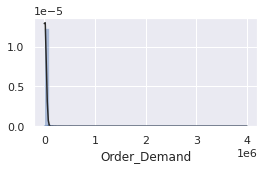

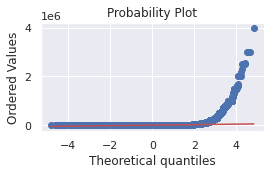

In [108]:
#Lets check the ditribution of the target variable (Order_Demand)
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 4,2

sb.distplot(df['Order_Demand'], fit=norm)

#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(df['Order_Demand'], plot=plt)
plt.show()

In [109]:
#The data is highly skewed, but since we'll be applying ARIMA, it's fine.
df['Order_Demand'].skew()

31.506080242695006

In [112]:
#Just in case if there needs to be some transformation, it can be done by either taking log values or using box cox.

## In case you need to normalize data, use Box Cox. Pick the one that looks MOST like a normal distribution.
# for i in [1,2,3,4,5,6,7,8]:
#     plt.hist(df['Order_Demand']**(1/i), bins= 40, normed=False)
#     plt.title("Box Cox transformation: 1/{}". format(str(i)))
#     plt.show()

Univariate Analysis - Warehouse, Product Category.



In [113]:
#Warehouse shipping by orders.
df['Warehouse'].value_counts().sort_values(ascending = False)

Whse_J    764215
Whse_A    142197
Whse_S     88024
Whse_C     42207
Name: Warehouse, dtype: int64

In [114]:
#The amount of orders shipped by each warehouse.
df.groupby('Warehouse').sum().sort_values('Order_Demand', ascending = False)
#Warehouse J is clearly shipping most orders. Although S is shipping more quantity within fewer requested orders.

,Order_Demand
Warehouse,
Whse_J,3362742530
Whse_S,1033121811
Whse_C,582004179
Whse_A,147646550


33


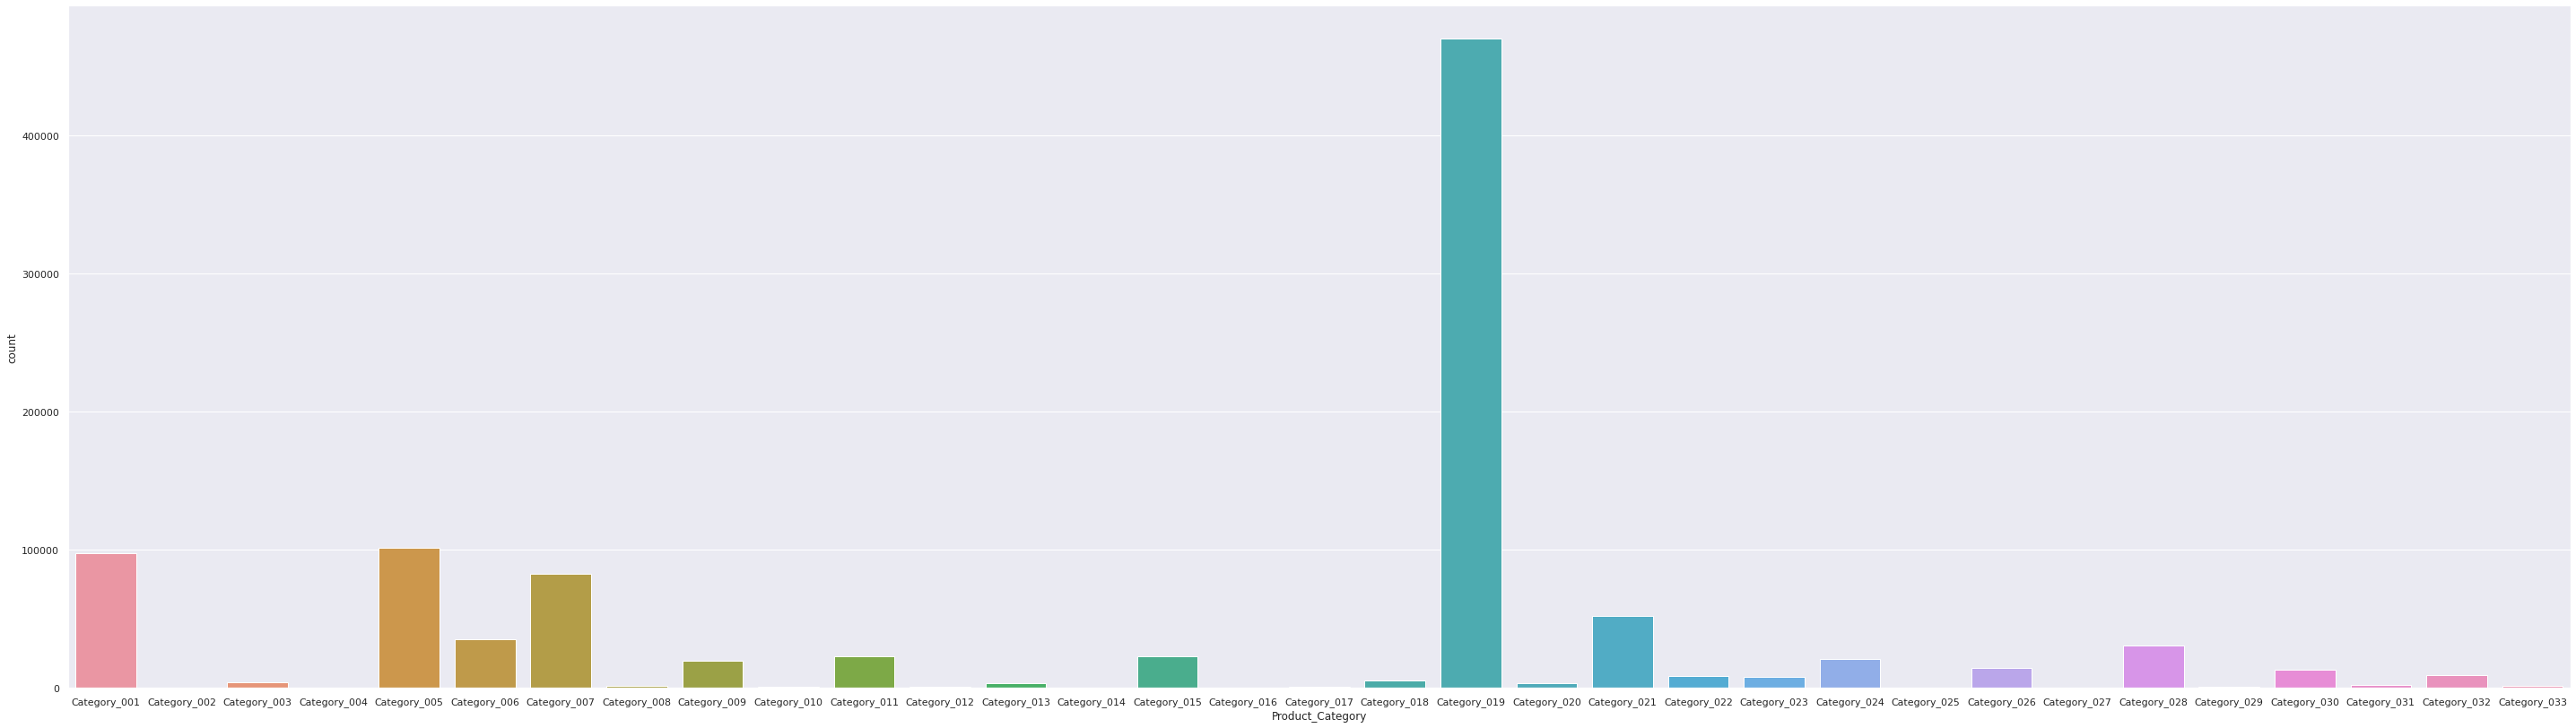

In [115]:
#Product Category.

print (len(df['Product_Category'].value_counts()))

rcParams['figure.figsize'] = 50,14
sb.countplot(df['Product_Category'].sort_values(ascending = True))

#There's a lot of orders on category19.

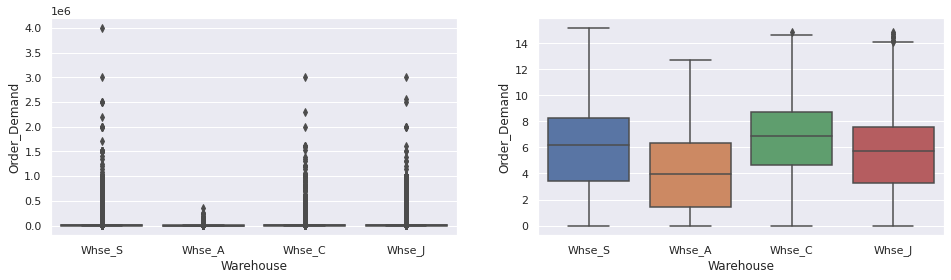

In [116]:
#Lets check the orders by warehouse.

#Checking with Boxplots
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 16,4
f, axes = plt.subplots(1, 2)
#Regular Data
fig3 = sb.boxplot( df['Warehouse'],df['Order_Demand'], ax = axes[0])
#Data with Log Transformation
fig4 = sb.boxplot( df['Warehouse'], np.log1p(df['Order_Demand']),ax = axes[1])

del fig3, fig4

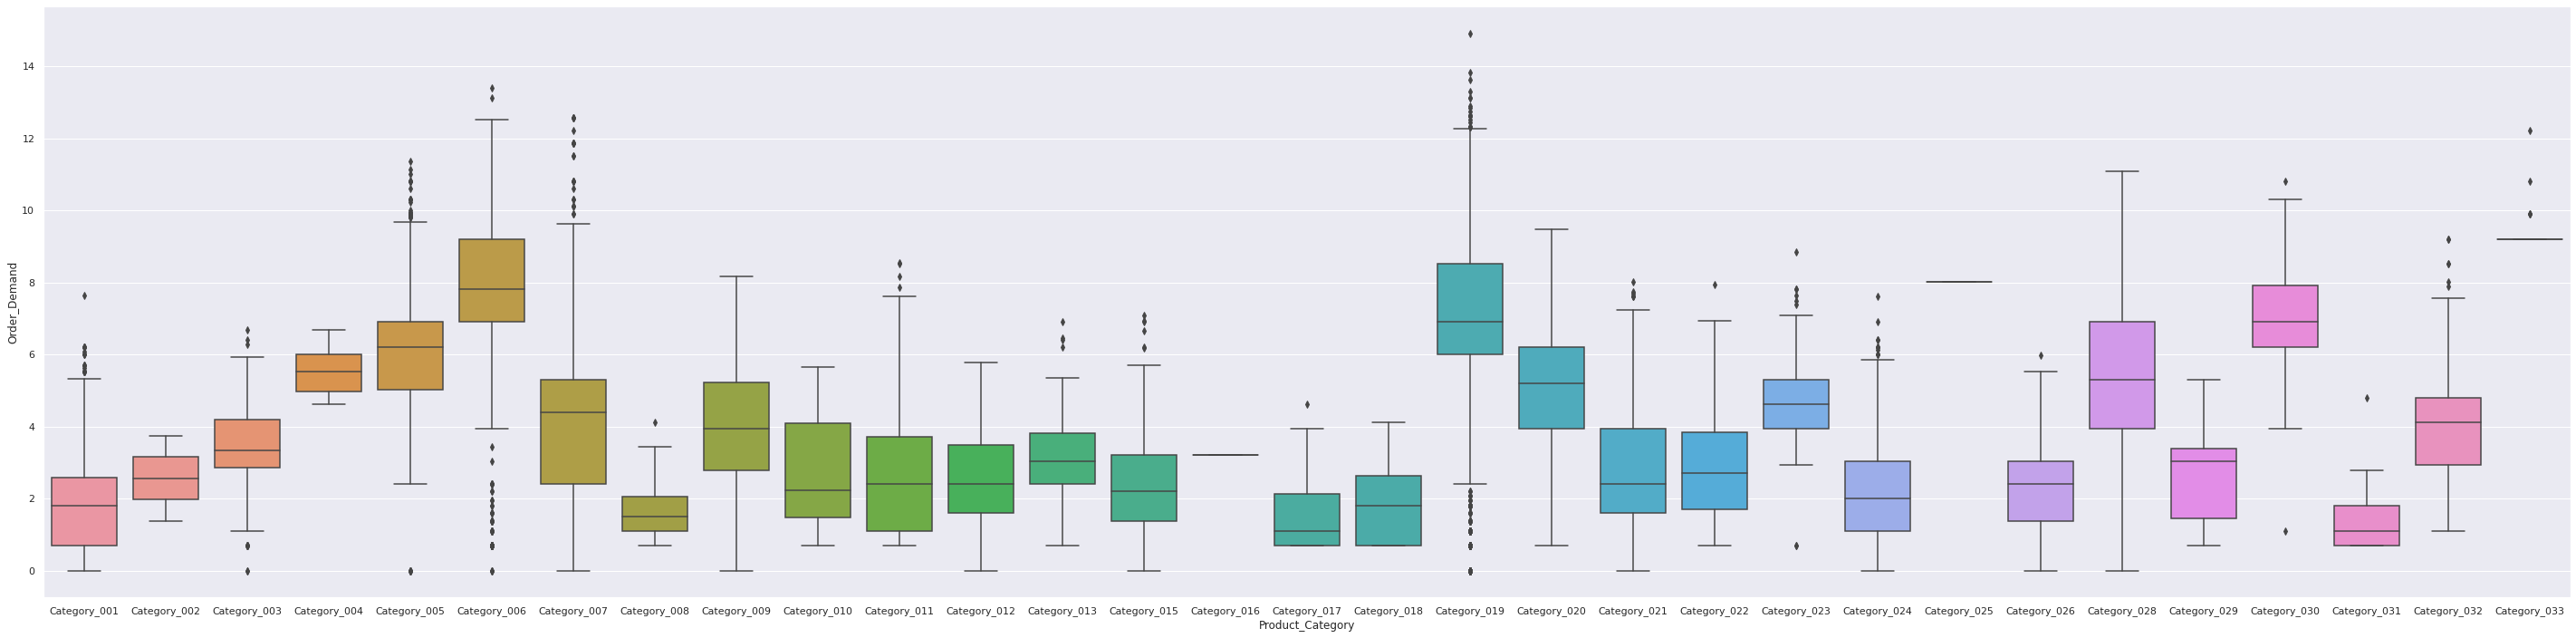

In [117]:
#Lets check the Orders by Product Category.
rcParams['figure.figsize'] = 50,12
#Taking subset of data temporarily for in memory compute.
df_temp = df.sample(n=20000).reset_index()
fig5 = sb.boxplot( df_temp['Product_Category'].sort_values(),np.log1p(df_temp['Order_Demand']))
del df_temp, fig5